# The Battle of Neighborhoods

## IBM Data Science Professional Certificate - Capstone Project

This notebook is the capstone project of the IBM Data Science Professional Certificate specialization in Coursera

In [1]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


#### Import libraries

In [2]:
import numpy as np

#import pandas
import pandas as pd

#HTTP requests
import requests

# import k-means for clustering
#import k-means
from sklearn.cluster import KMeans

# parsing HTML and XML documents
from bs4 import BeautifulSoup

#geocoder for OpenStreetMap data.
from geopy.geocoders import Nominatim

# map rendering library
import folium 

# tranform JSON file into a pandas dataframe - normalize semi-structured JSON data into a flat table
#from pandas.io.json import json_normalize
from pandas import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


## Assignment part I: create a table with PostalCodes, Boroughs and Neighborhoods of Toronto neighborhood

#### Get the postal codes

##### Parse Toronto neighborhood postal codes from Wikipedia

In [3]:
# Wikipedia page of Toronto neighborhood postal codes beginning with 'M'
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

#get the website data to parse
soup = BeautifulSoup(website_url,'lxml')

#Get the postal codes table
My_table = soup.find('table',{'class':'wikitable sortable'})
#filter out the table rows
rows = My_table.findAll('tr')

#parse string values from the table
res = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)

#convert to dataframe
df = pd.DataFrame(res, columns=["PostalCode", "Borough", "Neighborhood"])
#filter out data if borough is Not assigned
new_df = df[~df['Borough'].isin(['Not assigned'])]
#combine neighborhoods that exist in one postal code area
new_df2 = new_df.groupby('PostalCode').agg({'Borough':'first', 
                             'Neighborhood': ', '.join }).reset_index()

#review the resulting dataframe
print("dataframe shape:",new_df2.shape)
new_df2.head()

dataframe shape: (103, 3)


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Assignment part I results

#### Show the number of rows in the table

In [4]:
print("Number of rows of the dataframe:", new_df2.shape[0])

Number of rows of the dataframe: 103


## Assignment part II: Add latitude and longitude coordinates of each neighborhood

#### Add coordinates to the postal code dataframe

In [5]:
#get coordinates from csv file
#filePath = 'Geospatial_Coordinates.csv'
filePath = 'https://cocl.us/Geospatial_data'

#read the csv to a dataframe
df = pd.read_csv(filePath)
df.rename(columns={"Postal Code": "PostalCode"}, inplace=True)

#merge coordinates data with the postal code data
result = pd.merge(new_df2, df, how="left", on=["PostalCode"])

#review the resulting dataframe
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(result['Borough'].unique()),
        result.shape[0]))

The dataframe has 10 boroughs and 103 neighborhoods.


### Assignment part II results

#### Show the table with the latitude and longitude coordinates of each neighborhood

In [6]:
result

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


## Assignment part III: Explore and cluster the neighborhoods in the city of Toronto

##### Get Totonto's latitude and longitude coordinates

In [7]:
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="to_explorer")

#get the location
location = geolocator.geocode(address)
#parse the coordinates
latitude = location.latitude
longitude = location.longitude

#print the coordinates
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


#### Plot a map of Toronto and mark neighborhoods

In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
#show map
map_toronto

### Explore the first neighborhood in the dataframe using Foursquare API

##### Get the neighborhood's name

In [9]:
result.Neighborhood[0]
result.loc[0, 'Neighborhood']

'Malvern, Rouge'

##### Get the neighborhood's coordinates

In [10]:
# neighborhood latitude value
neighborhood_latitude = result.loc[0, 'Latitude'] 
# neighborhood longitude value
neighborhood_longitude = result.loc[0, 'Longitude']
# neighborhood name
neighborhood_name = result.loc[0, 'Neighborhood'] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Malvern, Rouge are 43.806686299999996, -79.19435340000001.


##### Foursquare API credentials

In [40]:
# The code was removed by Watson Studio for sharing.

##### Prepare URL for Foursquare API

In [12]:
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)

#### Query the Foursquare api

In [13]:
#HTTP request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60186221f6e2b76ae0d94ff0'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': 'Wendy’s',
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

##### Use the get_category_type function from the Foursquare lab

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


##### Clean the json and structure it into a pandas dataframe

In [15]:
#Get the venue from the results
venues = results['response']['groups'][0]['items']

# flatten JSON
nearby_venues = json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

##### Show results

In [16]:
nearby_venues

,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


### Explore all the neighborhoods in the city of Toronto

##### Create a function to repeat the same process to all the neighborhoods

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

##### Query Foursquare to get data of all the neighborhoods

In [18]:
DF_results4square = getNearbyVenues(result['Neighborhood'], result['Latitude'], result['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

##### Review the results

In [19]:
print(DF_results4square.shape)
DF_results4square.head()

(2137, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant


### Data processing

#### Check how many venues were returned for each neighborhood

In [20]:
DF_results4square.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
...,...,...,...,...,...,...
"Willowdale, Willowdale East",35,35,35,35,35,35
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4


#### Check the number of unique categories in the data

In [21]:
print('There are {} uniques categories.'.format(len(DF_results4square['Venue Category'].unique())))

There are 275 uniques categories.


#### Analyze Each Neighborhood

In [22]:
# one hot encoding
toronto_onehot = pd.get_dummies(DF_results4square[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(columns=['Neighborhood'],inplace=True)
DF_onehot = pd.concat([DF_results4square['Neighborhood'].to_frame(), toronto_onehot], axis=1)
print(DF_onehot.shape)
DF_onehot.head()

(2137, 275)


,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Check what are the most common venue categories

In [23]:
columns = DF_onehot.columns
index = ['count']
res = pd.DataFrame(index=index, columns=columns)
res.index.name = 'Category'

for column_name in DF_onehot.columns:
    if(column_name != 'Neighborhood'):
        res[column_name] = DF_onehot[DF_onehot[column_name] > 0].shape[0]
        
res.drop(['Neighborhood'], axis=1, inplace=True)
res_transposed = res.T 

res_transposed.sort_values(by='count', ascending=False).head(15)

Category,count
Coffee Shop,182
Café,92
Restaurant,62
Park,54
Pizza Place,54
Bakery,46
Italian Restaurant,45
Hotel,44
Sandwich Place,40
Japanese Restaurant,39


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
toronto_grouped = DF_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.038462,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.000000,0.0
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
92,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
93,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


#### Print each neighborhood along with the top 5 most common venues

In [25]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                             venue  freq
0                           Lounge  0.33
1                   Breakfast Spot  0.33
2        Latin American Restaurant  0.33
3               Mexican Restaurant  0.00
4  Molecular Gastronomy Restaurant  0.00


----Alderwood, Long Branch----
          venue  freq
0   Pizza Place  0.25
1      Pharmacy  0.12
2           Pub  0.12
3           Gym  0.12
4  Dance Studio  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
           venue  freq
0           Bank  0.09
1    Coffee Shop  0.09
2   Intersection  0.04
3    Bridal Shop  0.04
4  Shopping Mall  0.04


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4  Moroccan Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                     venue  freq
0              Coffee Shop  0.08
1           Sandwich Place  0.08
2       Italian Restaurant  0.08

#### Put results into a pandas dataframe
Write a function to sort the venues in descending order.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

####  Create the new dataframe and display the top 10 venues for each neighborhood.

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pub,Dance Studio,Gym,Pharmacy,Coffee Shop,Athletics & Sports,Yoga Studio,Diner,Discount Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Park,Supermarket,Shopping Mall,Bridal Shop,Sandwich Place,Restaurant,Pizza Place,Pharmacy
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Diner,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Pizza Place,Locksmith,Breakfast Spot,Juice Bar,Butcher,Restaurant


## k-means clustering

### Find the optimal k using silhouette and elbow methods
Run clustering with clusters range (1:10) to find th eoptimal k

In [28]:
from sklearn.metrics import silhouette_score

# sil - the silhouette score for different values of k
sil = []
# kInertia - the Within-Cluster-Sum of Squared Errors (WSS) for different values of k
kInertia = []

# define the maximal number of clusters
kmax = 10

# drop the Neighborhood column
tornoto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(tornoto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(tornoto_grouped_clustering, labels, metric = 'euclidean'))
    kInertia.append([kmeans.inertia_])
    print(k, silhouette_score(tornoto_grouped_clustering, labels, metric = 'euclidean'))
  

# find the k with the maximal silhouette score 
print( "The maximal silhouette score:", pd.Series(sil).max(), "at k=", pd.Series(sil).argmax()+2)
kclusters = pd.Series(sil).argmax()+2

2 0.310369199253713
3 0.34386727113505017
4 0.33611076025689385
5 0.29695786384110184
6 0.3632314547440628
7 0.2838989636236841
8 0.31097992535551194
9 0.10746214503954422
10 0.17352082711574243
The maximal silhouette score: 0.3632314547440628 at k= 6


#### Plot WSS Vs. k for the dataset - look for the elbow
WSS - Within Cluster Sum of Squared Errors

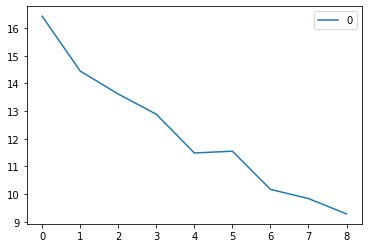

In [29]:
kdf = pd.DataFrame(kInertia)
#columns=['k','inertia']

kdf.plot(kind='line',legend='sc')

No clear elbow is detected in the graph
#### Plot silhouette score Vs. k for the dataset - look for the peak

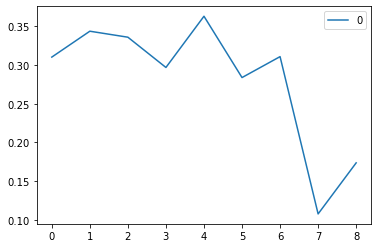

In [30]:
kdf = pd.DataFrame(sil)
#columns=['k','inertia']

kdf.plot(kind='line',legend='sc')

##### Run k-means with 6 clusters to cluster the neighborhoods

In [31]:
# create a dataframe without Neighborhood column
tornoto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tornoto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1, 5, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 0,
       1, 0, 1, 1, 1, 1, 0], dtype=int32)

##### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#toronto_venues_clustered = result

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
#toronto_venues_clustered = toronto_venues_clustered.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_venues_clustered = result.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_venues_clustered.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4.0,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,College Stadium
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1.0,Bar,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Breakfast Spot,Electronics Store,Restaurant,Rental Car Location,Bank,Medical Center,Intersection,Mexican Restaurant,Yoga Studio,Dog Run
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean BBQ Restaurant,Indian Restaurant,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Caribbean Restaurant,Bakery,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Hakka Restaurant,Electronics Store,Eastern European Restaurant


#### Visualize the resulting clusters

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

toronto_venues_clustered.dropna(inplace=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_venues_clustered['Latitude'], toronto_venues_clustered['Longitude'], toronto_venues_clustered['Neighborhood'], toronto_venues_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    clstr = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[clstr-1],
        fill=True,
        fill_color=rainbow[clstr-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Review cluster = 0

In [34]:
toronto_venues_clustered.loc[toronto_venues_clustered['Cluster Labels'] == 0, toronto_venues_clustered.columns[[2] + list(range(5, toronto_venues_clustered.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Milliken, Agincourt North, Steeles East, L'Amo...",0.0,Park,Intersection,Playground,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
21,"Willowdale, Newtonbrook",0.0,Park,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
23,York Mills West,0.0,Park,Convenience Store,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
25,Parkwoods,0.0,Park,Fireworks Store,Food & Drink Shop,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
40,"East Toronto, Broadview North (Old East York)",0.0,Park,Convenience Store,Metro Station,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
50,Rosedale,0.0,Park,Playground,Trail,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
74,Caledonia-Fairbanks,0.0,Park,Pool,Women's Store,Greek Restaurant,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
98,Weston,0.0,Park,Jewelry Store,Yoga Studio,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


#### Review cluster = 1

In [35]:
toronto_venues_clustered.loc[toronto_venues_clustered['Cluster Labels'] == 1, toronto_venues_clustered.columns[[2] + list(range(5, toronto_venues_clustered.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Rouge Hill, Port Union, Highland Creek",1.0,Bar,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner
2,"Guildwood, Morningside, West Hill",1.0,Breakfast Spot,Electronics Store,Restaurant,Rental Car Location,Bank,Medical Center,Intersection,Mexican Restaurant,Yoga Studio,Dog Run
3,Woburn,1.0,Coffee Shop,Korean BBQ Restaurant,Indian Restaurant,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,Cedarbrae,1.0,Caribbean Restaurant,Bakery,Fried Chicken Joint,Thai Restaurant,Athletics & Sports,Gas Station,Bank,Hakka Restaurant,Electronics Store,Eastern European Restaurant
5,Scarborough Village,1.0,Grocery Store,Playground,Jewelry Store,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
96,Humber Summit,1.0,Pizza Place,Intersection,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
99,Westmount,1.0,Discount Store,Intersection,Sandwich Place,Pizza Place,Middle Eastern Restaurant,Coffee Shop,Chinese Restaurant,Doner Restaurant,Distribution Center,Dog Run
100,"Kingsview Village, St. Phillips, Martin Grove ...",1.0,Park,Pizza Place,Sandwich Place,Bus Line,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio
101,"South Steeles, Silverstone, Humbergate, Jamest...",1.0,Grocery Store,Pizza Place,Fast Food Restaurant,Sandwich Place,Beer Store,Fried Chicken Joint,Pharmacy,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


#### Review cluster = 2

In [36]:
toronto_venues_clustered.loc[toronto_venues_clustered['Cluster Labels'] == 2, toronto_venues_clustered.columns[[2] + list(range(5, toronto_venues_clustered.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
90,"The Kingsway, Montgomery Road, Old Mill North",2.0,River,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Dessert Shop


#### Review cluster = 3

In [37]:
toronto_venues_clustered.loc[toronto_venues_clustered['Cluster Labels'] == 3, toronto_venues_clustered.columns[[2] + list(range(5, toronto_venues_clustered.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,"West Deane Park, Princess Gardens, Martin Grov...",3.0,Bakery,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner


#### Review cluster = 4

In [38]:
toronto_venues_clustered.loc[toronto_venues_clustered['Cluster Labels'] == 4, toronto_venues_clustered.columns[[2] + list(range(5, toronto_venues_clustered.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",4.0,Fast Food Restaurant,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,College Stadium


##### Review cluster = 5

In [39]:
toronto_venues_clustered.loc[toronto_venues_clustered['Cluster Labels'] == 5, toronto_venues_clustered.columns[[2] + list(range(5, toronto_venues_clustered.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,"Old Mill South, King's Mill Park, Sunnylea, Hu...",5.0,Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner
97,"Humberlea, Emery",5.0,Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Diner
